In [1]:
import math
import time
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Scripts.airfoil as af
import Scripts.fishUtilities as fu
import Scripts.fishFits as ff
import Scripts.surfaceAreaEstimators as sea

from pathlib import Path

In [2]:
imagePath = r'./Pictures'
databasePath = r'./'
figurePath = r'./Figures/'
    
specimen = r'silverEel'

In [3]:
imagePathSide = fu.get_image_files(imagePath, specimen + 'SideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, specimen + 'Side.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, specimen + 'TopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, specimen + 'Top.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

In [4]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]), np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    
    return ([areaRatioTop, areaTop, nacaArea], [cntsTop, cntsTopFull], [maxPointsTop, minPointsTop],
            [topFitTop, bottomFitTop], [m, thickness, d0], [tHullTop, bHullTop])

In [5]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    # Find the area ratio of fins and no fins
    areaSideFull = cv2.contourArea(cntsSideFull)
    areaSideNF = cv2.contourArea(cntsSide)
    areaRatioSide = (1-np.abs(areaSideNF/areaSideFull))
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)

    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    # get min and max points
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    
    #fit data
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    
    return (areaRatioSide, [cntsSide, cntsSideFull], [maxPointsSide, minPointsSide], [topFitSide, bottomFitSide], [tHullSide, bHullSide])

In [6]:
# Dictionaries for data
generalData = {'Species Name':[], 'Width Location':[], 'Max Width':[],
               'Height Location':[], 'Max Height':[], 'Side Area':[], 'Top Area':[] }
sideFitData = {'Species Name':[], 'Ta6':[], 'Ta5':[], 'Ta4':[], 'Ta3':[], 'Ta2':[], 'Ta1':[], 'Ta0':[],
              'Ba6':[], 'Ba5':[], 'Ba4':[], 'Ba3':[], 'Ba2':[], 'Ba1':[], 'Ba0':[]}
topFitData = {'Species Name':[], 'Ta4':[], 'Ta3':[], 'Ta2':[], 'Ta1':[], 'Ta0':[],
              'Ba4':[], 'Ba3':[], 'Ba2':[], 'Ba1':[], 'Ba0':[]}

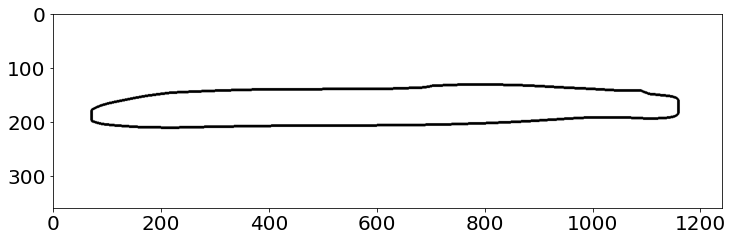

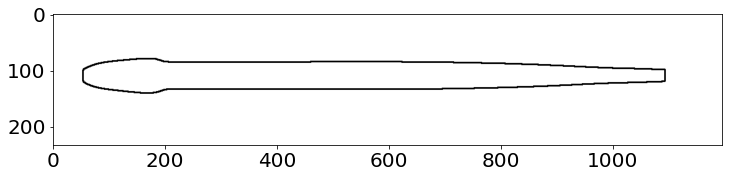

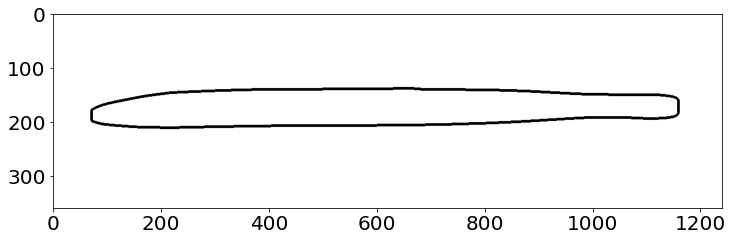

In [7]:
sideArea, sideContours, sidePoints, sideFits, sideHull = process_side([imageSide, imageSideFull])
cntsSideFull = sideContours[1]
cntsSide = sideContours[0]

topArea, topContours, topPoints, topPolyFits, nacaFits, topHull = process_top([imageTop])
cntsTopFull = topContours[1]
cntsTop = topContours[0]

# append general data to dictionary
generalData['Species Name'].append(specimen)
generalData['Width Location'].append(np.mean([topPoints[0][0], topPoints[1][0]]))
generalData['Max Width'].append(topPoints[0][1] + np.abs(topPoints[1][1]))
generalData['Height Location'].append(np.mean([sidePoints[0][0], sidePoints[1][0]]))
generalData['Max Height'].append(sidePoints[0][1] + np.abs(sidePoints[1][1]))
generalData['Side Area'].append(sideArea)
generalData['Top Area'].append(topArea[0])
    
# append side data to dictionary
sideFitData['Species Name'].append(specimen)
sideFitData['Ta6'].append(sideFits[0][0])
sideFitData['Ta5'].append(sideFits[0][1])
sideFitData['Ta4'].append(sideFits[0][2])
sideFitData['Ta3'].append(sideFits[0][3])
sideFitData['Ta2'].append(sideFits[0][4])
sideFitData['Ta1'].append(sideFits[0][5])
sideFitData['Ta0'].append(sideFits[0][6])
sideFitData['Ba6'].append(sideFits[1][0])
sideFitData['Ba5'].append(sideFits[1][1])
sideFitData['Ba4'].append(sideFits[1][2])
sideFitData['Ba3'].append(sideFits[1][3])
sideFitData['Ba2'].append(sideFits[1][4])
sideFitData['Ba1'].append(sideFits[1][5])
sideFitData['Ba0'].append(sideFits[1][6])
    
# append top data to dictionary
topFitData['Species Name'].append(specimen)
topFitData['Ta4'].append(nacaFits[0])
topFitData['Ta3'].append(nacaFits[1])
topFitData['Ta2'].append(nacaFits[2])
topFitData['Ta1'].append(0)
topFitData['Ta0'].append(0)
topFitData['Ba4'].append(nacaFits[0])
topFitData['Ba3'].append(nacaFits[1])
topFitData['Ba2'].append(nacaFits[2])
topFitData['Ba1'].append(0)
topFitData['Ba0'].append(0)

sideMask = np.zeros(imageSide.shape, dtype=np.uint8)
cv2.drawContours(sideMask, [cntsSideFull], -1, (255, 255, 255), 3)
sideMask = cv2.bitwise_not(sideMask)

sideMaskNF = np.zeros(imageSide.shape, dtype=np.uint8)
cv2.drawContours(sideMaskNF, [cntsSide], -1, (255, 255, 255), 3)
sideMaskNF = cv2.bitwise_not(sideMaskNF)

topMask = np.zeros(imageTop.shape, dtype=np.uint8)
cv2.drawContours(topMask, [cntsTopFull], -1, (255, 255, 255), 2)
topMask = cv2.bitwise_not(topMask)

plt.rcParams.update({'font.size': 20})
fig1, ax1 = plt.subplots(figsize=(12, 10))
ax1.imshow(sideMask)
#fig1.savefig(Path(figurePath).joinpath('sideContours.png'), facecolor='w', bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(12, 10))
ax2.imshow(topMask)
#fig2.savefig(Path(figurePath).joinpath('topContour.png'), facecolor='w', bbox_inches='tight')

fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.imshow(sideMaskNF)
#fig3.savefig(Path(figurePath).joinpath('sideContoursNF.png'), facecolor='w', bbox_inches='tight')

In [8]:
# All data into pandas dataframes
fish_general = pd.DataFrame(data=generalData)
fish_side = pd.DataFrame(data=sideFitData)    
fish_top = pd.DataFrame(data=topFitData)

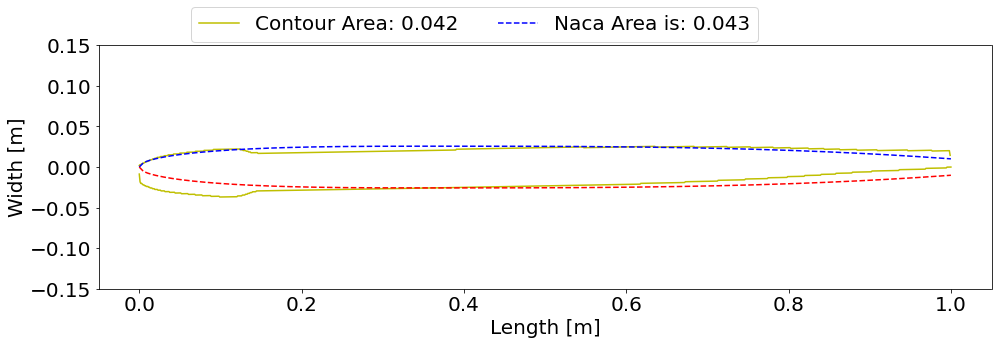

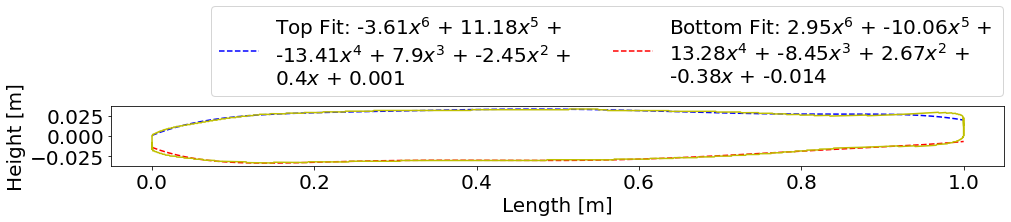

In [9]:
dx = np.linspace(0, 1.0, 200)
#nacaFits = [0.3973, 0.16, 0.01]
m = nacaFits[0]
thickness = nacaFits[1]
d0 = nacaFits[2]

topPolySide = np.poly1d(sideFits[0])
bottomPolySide = np.poly1d(sideFits[1])
topPolyTop = np.poly1d(topPolyFits[0])
bottomPolyTop = np.poly1d(topPolyFits[1])

X, Y = af.naca4_modified(dx, m, thickness, 1.0, d0)
fig4, ax4 = plt.subplots(figsize=(16, 15))
ax4.plot(topHull[0][0], topHull[0][1], 'y', label="Contour Area: " + str(np.round(topArea[1], 3)))
ax4.plot(topHull[1][0], topHull[1][1], 'y')
ax4.plot(X[0], Y[0], 'b--', label="Naca Area is: " + str(np.round(topArea[2], 3))) 
ax4.plot(X[1], Y[1], 'r--')
ax4.set_xlabel("Length [m]")
ax4.set_ylabel("Width [m]")
ax4.set_ylim([-.15, 0.15])
ax4.set_aspect('equal')
ax4.legend(loc='best', ncol=2, bbox_to_anchor=(0.75, 1.2))
#fig4.savefig(Path(figurePath).joinpath('NacaFit.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

sideFitData['Ta6'].append(sideFits[0][0])
sideFitData['Ta5'].append(sideFits[0][1])
sideFitData['Ta4'].append(sideFits[0][2])
sideFitData['Ta3'].append(sideFits[0][3])
sideFitData['Ta2'].append(sideFits[0][4])
sideFitData['Ta1'].append(sideFits[0][5])
sideFitData['Ta0'].append(sideFits[0][6])
sideFitData['Ba6'].append(sideFits[1][0])
sideFitData['Ba5'].append(sideFits[1][1])
sideFitData['Ba4'].append(sideFits[1][2])
sideFitData['Ba3'].append(sideFits[1][3])
sideFitData['Ba2'].append(sideFits[1][4])
sideFitData['Ba1'].append(sideFits[1][5])
sideFitData['Ba0'].append(sideFits[1][6])


fig5, ax5 = plt.subplots(figsize=(16, 15))
ax5.plot(dx, topPolySide(dx), 'b--', label='Top Fit: ' + str(np.round(sideFits[0][0],2)) + '$x^6$ + ' + str(np.round(sideFits[0][1],2)) + '$x^5$ + \n' + str(np.round(sideFits[0][2],2)) + '$x^4$ + ' + str(np.round(sideFits[0][3],2)) + '$x^3$ + ' + str(np.round(sideFits[0][4],2)) + '$x^2$ + \n' + str(np.round(sideFits[0][5],2)) + '$x$ + ' + str(np.round(sideFits[0][6],3)))
ax5.plot(dx, bottomPolySide(dx), 'r--', label='Bottom Fit: ' + str(np.round(sideFits[1][0],2)) + '$x^6$ + ' + str(np.round(sideFits[1][1],2)) + '$x^5$ + \n' + str(np.round(sideFits[1][2],2)) + '$x^4$ + ' + str(np.round(sideFits[1][3],2)) + '$x^3$ + ' + str(np.round(sideFits[1][4],2)) + '$x^2$ + \n' + str(np.round(sideFits[1][5],2)) + '$x$ + ' + str(np.round(sideFits[1][6],3)))

ax5.plot(sideHull[0][0], sideHull[0][1], 'y')
ax5.plot(sideHull[1][0], sideHull[1][1], 'y')
ax5.set_xlabel("Length [m]")
ax5.set_ylabel("Height [m]")
ax5.set_aspect('equal')
ax5.legend(loc='best', ncol=2, bbox_to_anchor=(0.1, 1.01))
#fig5.savefig(Path(figurePath).joinpath('sideFit.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [10]:
fish_general.head()

,Species Name,Width Location,Max Width,Height Location,Max Height,Side Area,Top Area
0,silverEel,0.36718,0.062408,0.331647,0.066535,0.057731,0.0


In [11]:
fish_side.head()

,Species Name,Ta6,Ta5,Ta4,Ta3,Ta2,Ta1,Ta0,Ba6,Ba5,Ba4,Ba3,Ba2,Ba1,Ba0
0,silverEel,-3.607247,11.181046,-13.408827,7.896057,-2.445462,0.403262,0.00059,2.945348,-10.062284,13.280793,-8.449827,2.672691,-0.379405,-0.01426


In [12]:
fish_top.head()

,Species Name,Ta4,Ta3,Ta2,Ta1,Ta0,Ba4,Ba3,Ba2,Ba1,Ba0
0,silverEel,0.36718,0.051408,0.010106,0,0,0.36718,0.051408,0.010106,0,0
